In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

In [2]:
import seaborn as sns
sns.set_style('darkgrid')

In [3]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [22]:
import datetime as dt
import yfinance as yf
from pandas_datareader import data as pdr
yf.pdr_override()

In [23]:
# Tickers
tickers = ['^GSPC', '^VIX', '^TNX', 'EURUSD=X', 'EURJPY=X', 'GBPJPY=X', 'EURGBP=X', 'GBPUSD=X']

# dates
startdate = '2015-1-1'
train_end = '2017-12-31'
test_start = '2018-01-01'
enddate = '2018-12-31'

# data Close
data_close = pdr.get_data_yahoo(tickers, start=startdate, end=enddate)['Adj Close']
print('\n--- Full dataset')
# display(data_close)

# data returns
data = data_close.shift(1) / data_close - 1
print('\n--- Full dataset returns')
# display(data)

# Sets
data_train = data[startdate:train_end].dropna()
data_test = data[test_start:enddate].dropna()
print('\n--- Train set unadjusted')
# display(data_train)
print('\n--- Test set unadjusted')
# display(data_test)

# mu sigma train
mu_train = data_train.mean()
sigma_train = data_train.std()
print('\n--- mu train:')
# display(pd.DataFrame(mu_train, columns=['Train set Mean']))
print('\n--- sigma train:')
# display(pd.DataFrame(sigma_train, columns=['Train set st dev']))

# Final sets
data_train_prod = (data_train - mu_train) / sigma_train
data_test_prod = (data_test - mu_train) / sigma_train
print('\n--- Train set adjusted')
# display(data_train_prod)
print('\n--- Test set adjusted')
# display(data_test_prod)

[*********************100%***********************]  8 of 8 completed

--- Full dataset

--- Full dataset returns

--- Train set unadjusted

--- Test set unadjusted

--- mu train:

--- sigma train:

--- Train set adjusted

--- Test set adjusted


In [27]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
train_gen_df = data_train_prod['^GSPC']
test_gen_df = data_test_prod['^GSPC']
train_data_gen = TimeseriesGenerator(train_gen_df.values, train_gen_df, length=30)
test_data_gen = TimeseriesGenerator(test_gen_df.values, test_gen_df, length=30)
train_data_gen[0][0].shape

(128, 30)

In [28]:
# Try longer/shorter batch size

## Wavenet

In [29]:
# https://github.com/usernaamee/keras-wavenet/blob/master/simple-generative-model.py

In [30]:
from tensorflow.keras.layers import Convolution1D, Convolution2D, Flatten, Dense, \
    Input, Lambda, Activation, BatchNormalization
from tensorflow import keras
import tensorflow

def WaveNetBlock(filters, kernel_size, dilation_rate, activation=None):
    def f(input_):
        residual = input_
        tanh_out = Convolution1D(filters, kernel_size,
                                       dilation_rate=dilation_rate,
                                       padding='same',
                                       activation='tanh')(input_)
        sigmoid_out = Convolution1D(filters, kernel_size,
                                          dilation_rate=dilation_rate,
                                          padding='same',
                                          activation='relu')(input_)
        merged = keras.layers.Multiply()([tanh_out, sigmoid_out])
        skip_out = Convolution1D(1, 1, activation=activation, padding='same')(merged)
        out = keras.layers.Add()([skip_out, residual])
        return out, skip_out
#         return skip_out
    return f

In [31]:
def evaluate_model(model, hist):
    total_mae = mean_absolute_error(train_gen_df[30:], np.zeros_like(train_gen_df[30:]))
    model_mae = mean_absolute_error(np.squeeze(model.predict(train_data_gen)), train_gen_df[30:]) 
    print('train', model_mae, total_mae, model_mae/total_mae)
    total_mae = mean_absolute_error(test_gen_df[30:], np.zeros_like(test_gen_df[30:]))
    model_mae = mean_absolute_error(np.squeeze(model.predict(test_data_gen)), test_gen_df[30:]) 
    print('test', model_mae, total_mae, model_mae/total_mae)
    plt.scatter(np.squeeze(model.predict(train_data_gen)), train_gen_df[30:])
    plt.title('training')
    plt.xlabel('prediction')
    plt.subplots()
    plt.scatter(np.squeeze(model.predict(test_data_gen)), test_gen_df[30:])
    plt.title('testing')
    plt.xlabel('prediction')
    pd.DataFrame(hist.history).plot()

Simple Dilated Covnet, filter=1, kernel=1

In [32]:
# try deactivate gpu here

train 0.6646960016100165 0.664672477008748 1.0000353927717518
test 0.8802986422019727 0.8802129578053762 1.0000973450752306


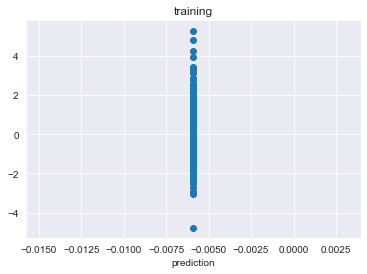

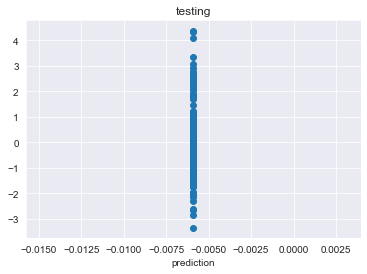

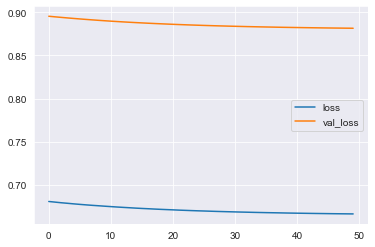

In [33]:
x = i = Input(shape=(30, 1))
x = BatchNormalization()(x)
x = Convolution1D(filters=1, kernel_size=1, dilation_rate=1, padding='same', activation='relu')(x)
x = Convolution1D(filters=1, kernel_size=1, dilation_rate=2, padding='same', activation='relu')(x)
x = Convolution1D(filters=1, kernel_size=1, dilation_rate=4, padding='same', activation='relu')(x)
x = Convolution1D(filters=1, kernel_size=1, dilation_rate=8, padding='same', activation='relu')(x)
x = Flatten()(x)

x = Dense(1, activation='linear', kernel_regularizer='l2')(x)


model = keras.Model(i, x)
model.compile(optimizer=tensorflow.keras.optimizers.Adam(1e-3), loss='mae')
hist = model.fit(train_data_gen, epochs=50, validation_data=test_data_gen, verbose=0)
evaluate_model(model, hist)
hist

Wavenet, filter=1, kernel=1

In [ ]:
x = i = Input(shape=(30, 1))
x = BatchNormalization()(x)
x, _ = WaveNetBlock(filters=1, kernel_size=1, dilation_rate=1, activation='relu')(x)
x, _ = WaveNetBlock(filters=1, kernel_size=1, dilation_rate=2, activation='relu')(x)
x, _ = WaveNetBlock(filters=1, kernel_size=1, dilation_rate=4, activation='relu')(x)
x, _ = WaveNetBlock(filters=1, kernel_size=1, dilation_rate=8, activation='relu')(x)
x = Flatten()(x)

x = Dense(1, activation='linear', kernel_regularizer='l2')(x)


model = keras.Model(i, x)
model.compile(optimizer=tensorflow.keras.optimizers.Adam(1e-3), loss='mae')
hist = model.fit(train_data_gen, epochs=50, validation_data=test_data_gen, verbose=0)
evaluate_model(model, hist)
hist

In [14]:
# x = WaveNetBlock(filters=4, kernel_size=8, dilation_rate=1, activation='relu')(x)
# x = WaveNetBlock(filters=8, kernel_size=4, dilation_rate=2, activation='relu')(x)
# x = WaveNetBlock(filters=16, kernel_size=2, dilation_rate=4, activation='relu')(x)
# x = WaveNetBlock(filters=32, kernel_size=1, dilation_rate=8, activation='relu')(x)

ConvNet, variable filters / kernel_size

train 0.4015928241798002 0.6567848917336968 0.6114525916083831
test 0.4015928241798002 0.6567848917336968 0.6114525916083831


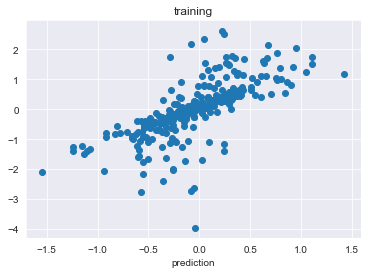

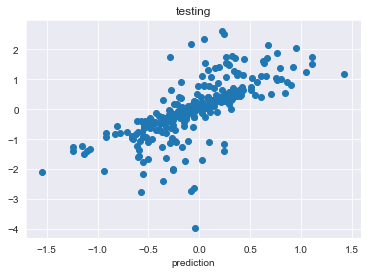

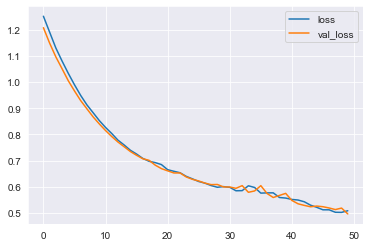

In [15]:
x = i = Input(shape=(30, 1))
x = BatchNormalization()(x)
x = Convolution1D(filters=4, kernel_size=8, dilation_rate=1, padding='same', activation='relu')(x)
x = Convolution1D(filters=8, kernel_size=4, dilation_rate=2, padding='same', activation='relu')(x)
x = Convolution1D(filters=16, kernel_size=2, dilation_rate=4, padding='same', activation='relu')(x)
x = Convolution1D(filters=32, kernel_size=1, dilation_rate=8, padding='same', activation='relu')(x)
x = Flatten()(x)
x = Dense(30, activation='relu', kernel_regularizer='l2')(x)
# x = Dense(30, activation='relu', kernel_regularizer='l2')(x)
x = Dense(1, activation='linear', kernel_regularizer='l2')(x)


model = keras.Model(i, x)
model.compile(optimizer=tensorflow.keras.optimizers.Adam(1e-3), loss='mae')
hist = model.fit(train_data_gen, epochs=50, validation_data=test_data_gen, verbose=0)
evaluate_model(model, hist)
hist

ConvNet, variable filters / kernel_size, final layer non-regularised

train 0.3441257364082499 0.6567848917336968 0.523955012880809
test 0.3441257364082499 0.6567848917336968 0.523955012880809


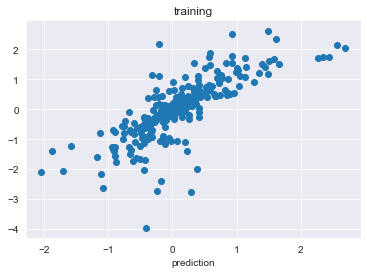

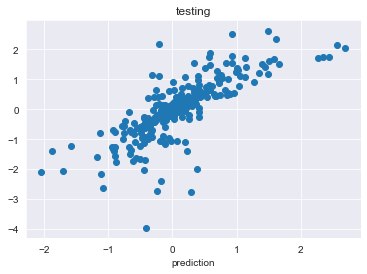

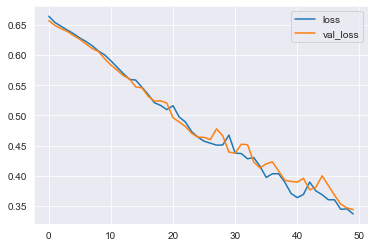

In [16]:
x = i = Input(shape=(30, 1))
x = BatchNormalization()(x)
x = Convolution1D(filters=4, kernel_size=8, dilation_rate=1, padding='same', activation='relu')(x)
x = Convolution1D(filters=8, kernel_size=4, dilation_rate=2, padding='same', activation='relu')(x)
x = Convolution1D(filters=16, kernel_size=2, dilation_rate=4, padding='same', activation='relu')(x)
x = Convolution1D(filters=32, kernel_size=1, dilation_rate=8, padding='same', activation='relu')(x)
x = Flatten()(x)
x = Dense(30, activation='relu')(x)
# x = Dense(30, activation='relu', kernel_regularizer='l2')(x)
x = Dense(1, activation='linear')(x)


model = keras.Model(i, x)
model.compile(optimizer=tensorflow.keras.optimizers.Adam(1e-3), loss='mae')
hist = model.fit(train_data_gen, epochs=50, validation_data=test_data_gen, verbose=0)
evaluate_model(model, hist)
hist

WaveNet, variable filter/kernel

train 0.5707618630787477 0.6567848917336968 0.8690240446489618
test 0.5707618630787477 0.6567848917336968 0.8690240446489618


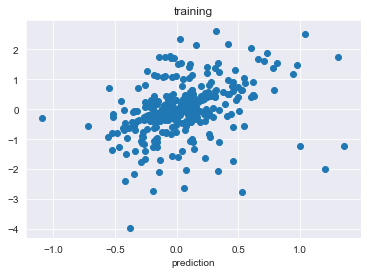

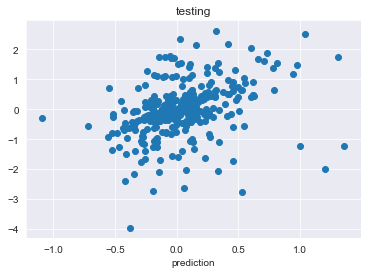

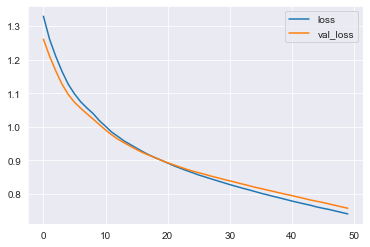

In [17]:
x = i = Input(shape=(30, 1))
x = BatchNormalization()(x)
x, _ = WaveNetBlock(filters=4, kernel_size=8, dilation_rate=1, activation='relu')(x)
x, _ = WaveNetBlock(filters=8, kernel_size=4, dilation_rate=2, activation='relu')(x)
x, _ = WaveNetBlock(filters=16, kernel_size=2, dilation_rate=4, activation='relu')(x)
x, _ = WaveNetBlock(filters=32, kernel_size=1, dilation_rate=8, activation='relu')(x)
x = Flatten()(x)
x = Dense(30, activation='relu', kernel_regularizer='l2')(x)
# x = Dense(30, activation='relu', kernel_regularizer='l2')(x)
x = Dense(1, activation='linear', kernel_regularizer='l2')(x)


model = keras.Model(i, x)
model.compile(optimizer=tensorflow.keras.optimizers.Adam(1e-3), loss='mae')
hist = model.fit(train_data_gen, epochs=50, validation_data=test_data_gen, verbose=0)
evaluate_model(model, hist)
hist

WaveNet, variable filter/kernel, non-regularised

train 0.5204655003756438 0.6567848917336968 0.7924443861700068
test 0.5204655003756438 0.6567848917336968 0.7924443861700068


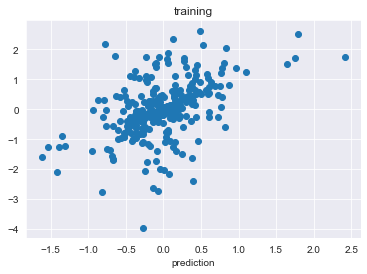

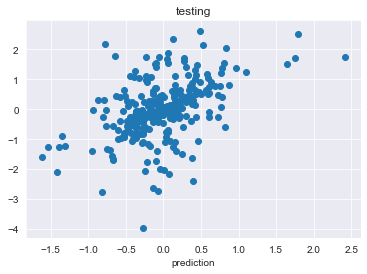

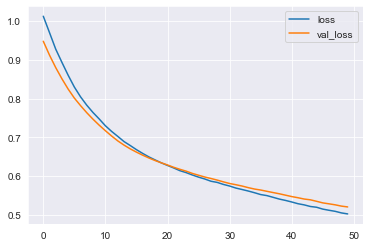

In [18]:
x = i = Input(shape=(30, 1))
x = BatchNormalization()(x)
x, _ = WaveNetBlock(filters=4, kernel_size=8, dilation_rate=1, activation='relu')(x)
x, _ = WaveNetBlock(filters=8, kernel_size=4, dilation_rate=2, activation='relu')(x)
x, _ = WaveNetBlock(filters=16, kernel_size=2, dilation_rate=4, activation='relu')(x)
x, _ = WaveNetBlock(filters=32, kernel_size=1, dilation_rate=8, activation='relu')(x)
x = Flatten()(x)
x = Dense(30, activation='relu')(x)
# x = Dense(30, activation='relu', kernel_regularizer='l2')(x)
x = Dense(1, activation='linear')(x)


model = keras.Model(i, x)
model.compile(optimizer=tensorflow.keras.optimizers.Adam(1e-3), loss='mae')
hist = model.fit(train_data_gen, epochs=50, validation_data=test_data_gen, verbose=0)
evaluate_model(model, hist)
hist

In [19]:
tf.config.experimental.list_logical_devices()

[LogicalDevice(name='/device:CPU:0', device_type='CPU'),
 LogicalDevice(name='/device:XLA_CPU:0', device_type='XLA_CPU'),
 LogicalDevice(name='/device:GPU:0', device_type='GPU'),
 LogicalDevice(name='/device:XLA_GPU:0', device_type='XLA_GPU')]